In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import pickle
import json
import os 

In [2]:
with open('/sietch_colab/akapoor/Infer_Demography/MomentsLD/LD_stats/sim_0/best_fit.pkl', 'rb') as f:
    best_fit = pickle.load(f)

In [4]:
best_fit['opt_params']

{'N_bottleneck': 1046.7403451405644,
 'N_recover': 19573.61677889993,
 't_bottleneck_start': 3486.3325671773696,
 't_bottleneck_end': 154.42586757349517,
 'N0': 17865.117115229692}

In [5]:
with open('/sietch_colab/akapoor/Infer_Demography/ld_experiments/bottleneck/simulations/0/sampled_params.pkl', 'rb') as f:
    sampled_params = pickle.load(f)

In [6]:
sampled_params

{'N0': 15931.20887400734,
 'N_bottleneck': 933.4301570891473,
 'N_recover': 17454.762558404884,
 't_bottleneck_start': 2606.881069748114,
 't_bottleneck_end': 250.68375662023925}

In [1]:
#!/usr/bin/env python3
"""
Gather all simulations and plot Moments-LD estimates vs. true parameters,
colour-coded by log-likelihood.  True values are on the *y-axis*.
"""

from pathlib import Path
import pickle
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import numpy as np

# ------------------------------------------------------------------------
SIM_BASEDIR = Path(
    "/sietch_colab/akapoor/Infer_Demography/ld_experiments/bottleneck/simulations"
)
LD_ROOT = Path(
    "/sietch_colab/akapoor/Infer_Demography/MomentsLD/LD_stats"
)

PARAM_NAMES = [
    "N_bottleneck",
    "N_recover",
    "t_bottleneck_start",
    "t_bottleneck_end",
    "N0",
]

true_vecs, est_vecs, ll_vec = [], [], []

# ---------------------------------------------------------------- collect ----
for sim_dir in sorted(SIM_BASEDIR.iterdir()):
    sid = sim_dir.name                       # e.g. "0", "7", …
    best_fit_pkl = LD_ROOT / f"sim_{sid}" / "best_fit.pkl"
    if not best_fit_pkl.exists():
        print(f"skip sim {sid}: best_fit.pkl missing")
        continue

    true_vals = pickle.load((sim_dir / "sampled_params.pkl").open("rb"))
    result    = pickle.load(best_fit_pkl.open("rb"))

    true_vecs.append(true_vals)
    est_vecs.append(result["opt_params"])
    ll_vec.append(result["loglik"])

if not true_vecs:
    raise RuntimeError("No simulations found – nothing to plot!")

# ---------------------------------------------------------------- plot -------
norm   = colors.Normalize(vmin=min(ll_vec), vmax=max(ll_vec))
cmap   = cm.get_cmap("viridis")
colour = cmap(norm(ll_vec))

n = len(PARAM_NAMES)
fig, axes = plt.subplots(1, n, figsize=(3 * n, 3), squeeze=False)

for i, p in enumerate(PARAM_NAMES):
    ax = axes[0, i]
    x  = [d[p] for d in est_vecs]     # estimated on x-axis
    y  = [d[p] for d in true_vecs]    # true on y-axis

    ax.scatter(x, y, s=25, c=colour)
    ax.plot([min(x + y), max(x + y)], [min(x + y), max(x + y)],
            ls="--", lw=0.7, color="grey")

    ax.set_xlabel(f"MomentsLD {p}")
    ax.set_ylabel(f"True {p}")

# colour-bar
fig.subplots_adjust(right=0.88)
cax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, label="log-likelihood")

fig.tight_layout(rect=[0, 0, 0.88, 1])
fig.savefig("scatter_momentsLD_vs_true.png", dpi=300)
print("✓ wrote scatter_momentsLD_vs_true.png")


FileNotFoundError: [Errno 2] No such file or directory: '/sietch_colab/akapoor/Infer_Demography/ld_experiments/bottleneck/simulations'

In [18]:
for i in np.arange(10):
    with open(f'/sietch_colab/akapoor/Infer_Demography/ld_experiments/bottleneck/simulations/{i}/sampled_params.pkl', 'rb') as f:
        sampled_params = pickle.load(f)
        print(f"Simulation {i} sampled parameters:")
        for key, value in sampled_params.items():
            print(f"{key}: {value}")

Simulation 0 sampled parameters:
N0: 18100.59942928492
N_bottleneck: 252.9487475496224
N_recover: 16417.01412335578
t_bottleneck_start: 2229.4719476247537
t_bottleneck_end: 474.5141100990196
Simulation 1 sampled parameters:
N0: 15253.366348616304
N_bottleneck: 597.480344803044
N_recover: 13488.673407238113
t_bottleneck_start: 2852.2234271014677
t_bottleneck_end: 210.9831622908427
Simulation 2 sampled parameters:
N0: 6134.147836857304
N_bottleneck: 1117.2526103479013
N_recover: 13949.635074110645
t_bottleneck_start: 2740.1477599640248
t_bottleneck_end: 560.9526408459219
Simulation 3 sampled parameters:
N0: 5766.677408198906
N_bottleneck: 186.97186626857408
N_recover: 14958.31302912772
t_bottleneck_start: 2026.7823692692637
t_bottleneck_end: 268.5490454881931
Simulation 4 sampled parameters:
N0: 14181.20464994994
N_bottleneck: 266.9485732885138
N_recover: 6878.352576780438
t_bottleneck_start: 2898.8686321385476
t_bottleneck_end: 1125.948464769022
Simulation 5 sampled parameters:
N0: 4477

In [1]:
import pickle
with open('/sietch_colab/akapoor/Infer_Demography/experiments/bottleneck/inferences/sim_0/dadi/fit_params.pkl', 'rb') as f:
    dadi_fit_params = pickle.load(f)

In [2]:
dadi_fit_params

{'best_params': [array([13235.39645879,  1467.69891925,  3189.65715519,  2456.83856461,
           887.78712107])],
 'best_lls': [-140.18919010680474]}

In [3]:
with open('/sietch_colab/akapoor/Infer_Demography/experiments/bottleneck/simulations/0/sampled_params.pkl', 'rb') as f:
    sampled_params = pickle.load(f)

In [4]:
sampled_params

{'N0': 13235.39645879176,
 'N_bottleneck': 1467.6989192511476,
 'N_recover': 3541.063247906867,
 't_bottleneck_start': 2180.707729594059,
 't_bottleneck_end': 686.6602336389819}

In [1]:
import pickle
with open('/home/akapoor/kernlab/Infer_Demography/experiments/split_isolation/modeling/features_df.pkl', 'rb') as f:
    features_df = pickle.load(f)

with open('/home/akapoor/kernlab/Infer_Demography/experiments/split_isolation/modeling/targets_df.pkl', 'rb') as f:
    targets_df = pickle.load(f)

In [2]:
features_df

,dadi_N0,dadi_N1,dadi_N2,dadi_m,dadi_t_split,momentsLD_N0,momentsLD_N1,momentsLD_N2,momentsLD_t_split,moments_N0,moments_N1,moments_N2,moments_m,moments_t_split
0,27051.562034,9949.378242,28082.614239,1.000000e-04,20000.000000,0.000105,7994.337919,21422.108537,16877.797163,27051.562034,9352.126623,26864.245537,1.000000e-04,8927.871648
1,5305.061322,27749.605542,23754.806228,9.582252e-05,15789.871745,0.000092,24449.426021,23377.603484,13527.806240,5305.061322,25111.606610,21847.223620,1.000000e-04,13472.235464
2,892.646884,4144.794726,9465.692506,6.043604e-05,11920.055913,0.000030,3903.313494,11639.600790,16024.431945,892.646884,5205.814538,11866.869716,4.580140e-05,15482.503953
3,19694.516099,259.300264,27107.609489,7.448504e-06,10156.868476,0.000013,4190.264888,132138.975842,3981.106398,19694.516099,356.684642,30000.000000,7.045962e-07,6099.281912
4,1989.369097,12427.192636,19420.645371,1.000000e-08,2610.777694,0.000012,9149.690887,12481.147767,2040.356183,1989.369097,11772.023104,13416.484058,1.000000e-08,2264.584641
5,16354.776312,15772.093800,1981.981428,3.787637e-05,11220.777624,0.000019,17309.154642,2995.717584,13055.435774,16354.776312,20534.549276,2683.934423,1.754561e-05,9097.942884
6,20724.657112,8198.207681,15468.624606,7.375815e-05,9156.043594,0.000055,9343.365977,14421.681336,12115.132336,20724.657112,8160.467559,15457.205180,7.391561e-05,10565.725350
7,11046.918419,14301.561548,29230.637862,6.876497e-05,3896.273793,0.000172,8901.590328,18864.619718,6730.682371,11046.918419,14391.228542,30000.000000,4.595811e-05,3160.414693
8,8132.128583,21576.121740,20225.301189,1.000000e-04,13298.096884,0.000088,21661.696096,16506.883109,11471.758462,8132.128583,20406.116771,19115.703933,1.000000e-04,10946.701708
9,20598.423214,11106.480829,9888.703281,1.428229e-05,9747.122359,0.000022,11795.976739,10657.338593,14990.303983,20598.423214,11393.364741,10154.342320,1.406746e-05,10127.558813


In [3]:
targets_df

,N0,N1,N2,m,t_split
0,27051.562034,7838.403122,22136.756040,0.000084,15727.693879
1,5305.061322,24058.315363,22966.330333,0.000076,13371.913601
2,892.646884,3897.212683,12243.226270,0.000028,15907.489103
3,19694.516099,308.414489,29639.305714,0.000012,11436.148031
4,1989.369097,9329.663905,14293.115351,0.000009,2123.304935
5,16354.776312,17026.067954,3003.480890,0.000018,13052.371370
6,20724.657112,8608.476479,15386.152568,0.000048,9019.781476
7,11046.918419,11344.860805,29819.918632,0.000057,3825.123643
8,8132.128583,19417.398262,16510.087674,0.000084,11050.358315
9,20598.423214,11909.330914,11143.304415,0.000020,14952.875347


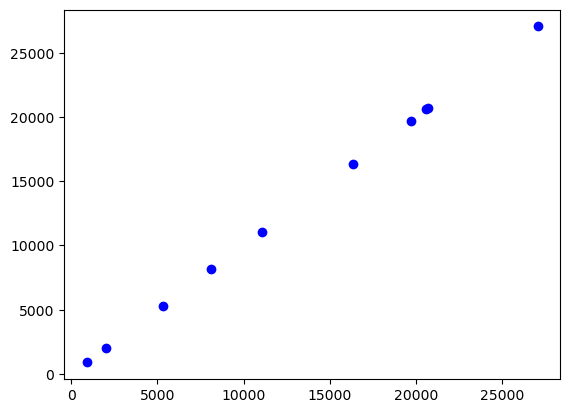

In [17]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(features_df['dadi_N0'], targets_df['N0'], c='blue', label='N1')

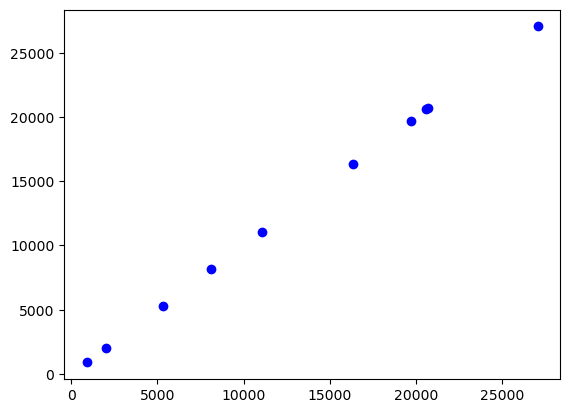

In [18]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(features_df['moments_N0'], targets_df['N0'], c='blue', label='N1')

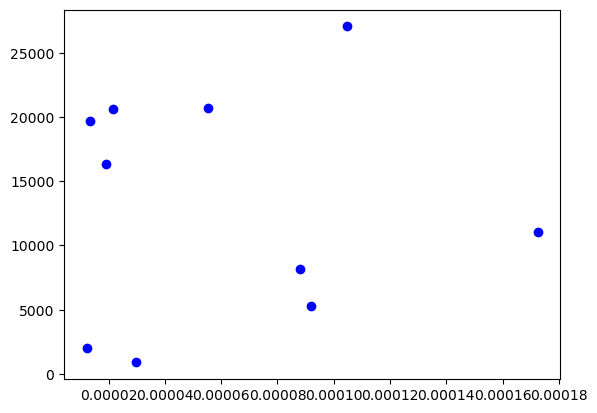

In [19]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(features_df['momentsLD_N0'], targets_df['N0'], c='blue', label='N1')

In [1]:
import pickle
from pathlib import Path
from typing import Union, Iterable, Dict, List

import pandas as pd
import matplotlib.pyplot as plt


def plot_estimates_vs_truth_grid(
    features_path: Union[str, Path],
    targets_path:  Union[str, Path],
    *,
    tools: Iterable[str] = ("dadi", "moments", "momentsLD"),
    params: Iterable[str] | None = None,
    figsize_per_panel: tuple[float, float] = (3.0, 3.0),
    fig_kw: Dict = None,
):
    """
    Draw a grid of scatter‑plots with one panel per (tool, parameter).

    Parameters
    ----------
    features_path, targets_path
        Pickles produced by your workflow (`features_df.pkl`, `targets_df.pkl`).
    tools
        Which tool prefixes to show (must match column prefixes in features_df).
    params
        Which base parameters (N0, N1, …) to plot.  If None, take the
        intersection of all tools' available parameters *and* targets' columns.
    figsize_per_panel
        Size (width, height) of each subplot in inches.
    fig_kw
        Extra kwargs to `plt.figure`.

    Returns
    -------
    matplotlib.figure.Figure
    """
    # ------------------ load -----------------------------------------------------------------
    features_df: pd.DataFrame = pickle.load(Path(features_path).open("rb"))
    targets_df:  pd.DataFrame = pickle.load(Path(targets_path).open("rb"))

    # ------------------ infer parameter list -------------------------------------------------
    if params is None:
        common: set[str] = set(targets_df.columns)
        for tool in tools:
            has = {c.split("_", 1)[1] for c in features_df.columns if c.startswith(f"{tool}_")}
            common &= has
        if not common:
            raise ValueError("No common parameters across selected tools & targets.")
        params = sorted(common)

    tools = list(tools)
    n_rows, n_cols = len(tools), len(params)

    fig_kw = fig_kw or {}
    fig = plt.figure(figsize=(figsize_per_panel[0] * n_cols,
                              figsize_per_panel[1] * n_rows),
                     **fig_kw)

    for r, tool in enumerate(tools):
        for c, p in enumerate(params):
            ax = fig.add_subplot(n_rows, n_cols, r * n_cols + c + 1)
            x = features_df[f"{tool}_{p}"]
            y = targets_df[p]
            ax.scatter(x, y, s=18, alpha=0.75)
            # identity line
            lims = [min(x.min(), y.min()), max(x.max(), y.max())]
            ax.plot(lims, lims, "k--", linewidth=1)
            ax.set_aspect("equal", adjustable="box")

            if r == 0:
                ax.set_title(p)
            if c == 0:
                ax.set_ylabel(f"{tool}\nTrue")
            else:
                ax.set_ylabel("")
            ax.set_xlabel("Estimated" if r == n_rows - 1 else "")

    fig.tight_layout()
    return fig



In [2]:
# --------------------------------------------------------------------------- #
# Example usage (remove or modify when integrating into your codebase):
fig = plot_estimates_vs_truth_grid(
    "/projects/kernlab/akapoor/Infer_Demography/experiments/split_isolation/modeling/features_df.pkl",
    "/projects/kernlab/akapoor/Infer_Demography/experiments/split_isolation/modeling/targets_df.pkl",
)
fig.show()


ValueError: No common parameters across selected tools & targets.

In [7]:
with open('/home/akapoor/kernlab/Infer_Demography/experiments/bottleneck/inferences/sim_0/all_inferences.pkl', 'rb') as f:
    all_inferences = pickle.load(f)

In [8]:
all_inferences

{'moments': {'best_params': [{'N0': 9481.003664497039,
    'N_bottleneck': 1318.08079190033,
    'N_recover': 10750.2739136192,
    't_bottleneck_start': 1704.418022556448,
    't_bottleneck_end': 1349.2325573980834}],
  'best_lls': [121.3273581738431]},
 'dadi': {'best_params': [{'N0': 9481.003664497039,
    'N_bottleneck': 1318.08079190033,
    'N_recover': 9696.35814688548,
    't_bottleneck_start': 2057.5929262416744,
    't_bottleneck_end': 1700.0}],
  'best_lls': [-112.87290080218736]},
 'momentsLD': {'best_params': {'N_bottleneck': 12496728.818110188,
   'N_recover': 7199.032213983785,
   't_bottleneck_start': 22033.820875747195,
   't_bottleneck_end': 11989.194438621782,
   'N0': 9481.003664497039},
  'best_lls': 451.8965469040465}}

In [1]:
import pickle
import matplotlib.pyplot as plt
with open('/home/akapoor/kernlab/Infer_Demography/debugging_experiments/split_migration/inferences/sim_0/Moments/best_fit.pkl', 'rb') as f:
    best_fit = pickle.load(f)

with open('/home/akapoor/kernlab/Infer_Demography/debugging_experiments/split_migration/simulations/0/sampled_params.pkl', 'rb') as f:
    sampled_params = pickle.load(f)

In [2]:
best_fit

{'best_params': {'N_ANC': 16890.4656029697,
  'N1': 6588.020251708551,
  'N2': 28109.483608963837,
  'T': 7968.033879213617,
  'm12': 7.327413515767458e-05,
  'm21': 7.000929248348781e-05},
 'best_ll': 1606433.4015414761,
 'status': 3}

In [3]:
sampled_params

{'N0': 16841.16284492997,
 'N1': 5958.309349156618,
 'N2': 28445.7364679629,
 'm12': 9.759970351706788e-05,
 'm21': 6.196811228818695e-05,
 't_split': 8161.930727838847}

In [5]:
import pickle
import matplotlib.pyplot as plt
from pathlib import Path

exp_root = Path("/home/akapoor/kernlab/Infer_Demography/debugging_experiments/split_migration")
mode = "Dadi"   # or "Dadi"
num_reps = 10      # number of replicate directories

param_names = ["N_ANC","N1","N2","T","m12","m21"]
true_names  = ["N0","N1","N2","t_split","m12","m21"]

# Collect fitted and true parameters
fitted_all = {p: [] for p in param_names}
true_all   = {p: [] for p in param_names}

for rep in range(num_reps):
    best_path = exp_root / f"inferences/sim_{rep}/{mode}/best_fit.pkl"
    true_path = exp_root / f"simulations/{rep}/sampled_params.pkl"

    if not (best_path.exists() and true_path.exists()):
        print(f"rep {rep} missing — skipping")
        continue

    best_fit = pickle.loads(best_path.read_bytes())
    sampled  = pickle.loads(true_path.read_bytes())

    for p, tp in zip(param_names,true_names):
        fitted_all[p].append(best_fit["best_params"][p])
        true_all[p].append(sampled[tp])

# Make scatterplots: one panel per parameter
fig, axes = plt.subplots(2,3,figsize=(12,8),dpi=150,constrained_layout=True)
axes = axes.ravel()

for i,p in enumerate(param_names):
    ax = axes[i]
    ax.scatter(true_all[p], fitted_all[p], s=20, alpha=0.7)
    # 1:1 reference line
    mn = min(true_all[p] + fitted_all[p])
    mx = max(true_all[p] + fitted_all[p])
    ax.plot([mn,mx],[mn,mx], "r--", lw=1)
    ax.set_xscale("log"); ax.set_yscale("log")
    ax.set_xlabel(f"True {p}")
    ax.set_ylabel(f"Fitted {p}")
    ax.set_title(p)

plt.suptitle(f"{mode} – fitted vs true across {num_reps} simulations", fontsize=14)
out = exp_root / f"inferences/scatter_all_params_{mode}.png"
plt.savefig(out)
plt.close()
print(f"saved {out}")


saved /home/akapoor/kernlab/Infer_Demography/debugging_experiments/split_migration/inferences/scatter_all_params_Dadi.png


In [2]:
# Plot dadi vs moments inferences for bottleneck experiment - CORRECTED VERSION
import pickle
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Load data from all_inferences.pkl files across simulations
exp_root = Path('/sietch_colab/akapoor/Infer_Demography/experiments/drosophila_three_epoch')
sim_dirs = sorted([d for d in exp_root.glob('inferences/sim_*') if d.is_dir()])

dadi_estimates = {}
moments_estimates = {}
true_params = {}

# Collect data from all simulations
for sim_dir in sim_dirs:
    sim_id = sim_dir.name.split('_')[1]  # Extract sim number
    all_inferences_file = sim_dir / 'all_inferences.pkl'
    true_params_file = exp_root / f'simulations/{sim_id}/sampled_params.pkl'
    
    if all_inferences_file.exists() and true_params_file.exists():
        try:
            # Load inferences
            with open(all_inferences_file, 'rb') as f:
                all_inferences = pickle.load(f)
            
            # Load true parameters
            with open(true_params_file, 'rb') as f:
                true_vals = pickle.load(f)
            
            # Extract dadi and moments parameters - CORRECTED FOR LIST FORMAT
            if 'dadi' in all_inferences and 'moments' in all_inferences:
                dadi_params = all_inferences['dadi']['best_params']
                moments_params = all_inferences['moments']['best_params']
                
                # Handle list of parameter dictionaries (take the best/first one)
                if isinstance(dadi_params, list) and len(dadi_params) > 0:
                    dadi_best = dadi_params[0]  # Take first (best) fit
                else:
                    dadi_best = dadi_params
                    
                if isinstance(moments_params, list) and len(moments_params) > 0:
                    moments_best = moments_params[0]  # Take first (best) fit  
                else:
                    moments_best = moments_params
                
                if isinstance(dadi_best, dict) and isinstance(moments_best, dict):
                    # Find common parameters between both methods
                    common_param_names = set(dadi_best.keys()) & set(moments_best.keys())
                    
                    for param in common_param_names:
                        if param not in dadi_estimates:
                            dadi_estimates[param] = []
                            moments_estimates[param] = []
                            true_params[param] = []
                        
                        dadi_estimates[param].append(dadi_best[param])
                        moments_estimates[param].append(moments_best[param])
                        true_params[param].append(true_vals.get(param, np.nan))
                        
        except Exception as e:
            print(f"Error loading sim {sim_id}: {e}")
            continue

# Get common parameters
common_params = sorted(set(dadi_estimates.keys()) & set(moments_estimates.keys()) & set(true_params.keys()))
print(f"Common parameters found: {common_params}")
print(f"Number of simulations loaded: {len(dadi_estimates.get(common_params[0], []))}")

# Create plots
n_params = len(common_params)
if n_params > 0:
    fig, axes = plt.subplots(1, n_params, figsize=(4 * n_params, 4))
    if n_params == 1:
        axes = [axes]

    for i, param in enumerate(common_params):
        ax = axes[i]
        x = np.array(dadi_estimates[param])
        y = np.array(moments_estimates[param])
        true_vals = np.array(true_params[param])
        
        # Create scatter plot colored by true values
        scatter = ax.scatter(x, y, c=true_vals, cmap='viridis', s=30, alpha=0.8)
        
        # Add 1:1 line
        min_val = min(x.min(), y.min())
        max_val = max(x.max(), y.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1, label='1:1 line')
        
        ax.set_xlabel(f'dadi {param}')
        ax.set_ylabel(f'moments {param}')
        ax.set_title(f'{param}')
        ax.grid(True, alpha=0.3)

    # Add colorbar
    plt.colorbar(scatter, ax=axes, label='True parameter value', shrink=0.8)
    plt.suptitle('dadi vs moments parameter inferences (bottleneck experiment)', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("No common parameters found to plot")

Common parameters found: []


IndexError: list index out of range

Common parameters found: ['N_CEU', 'N_YRI', 'N_anc', 'T_split', 'm_YRI_CEU']
Number of simulations loaded: 100


/tmp/ipykernel_889467/758101744.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


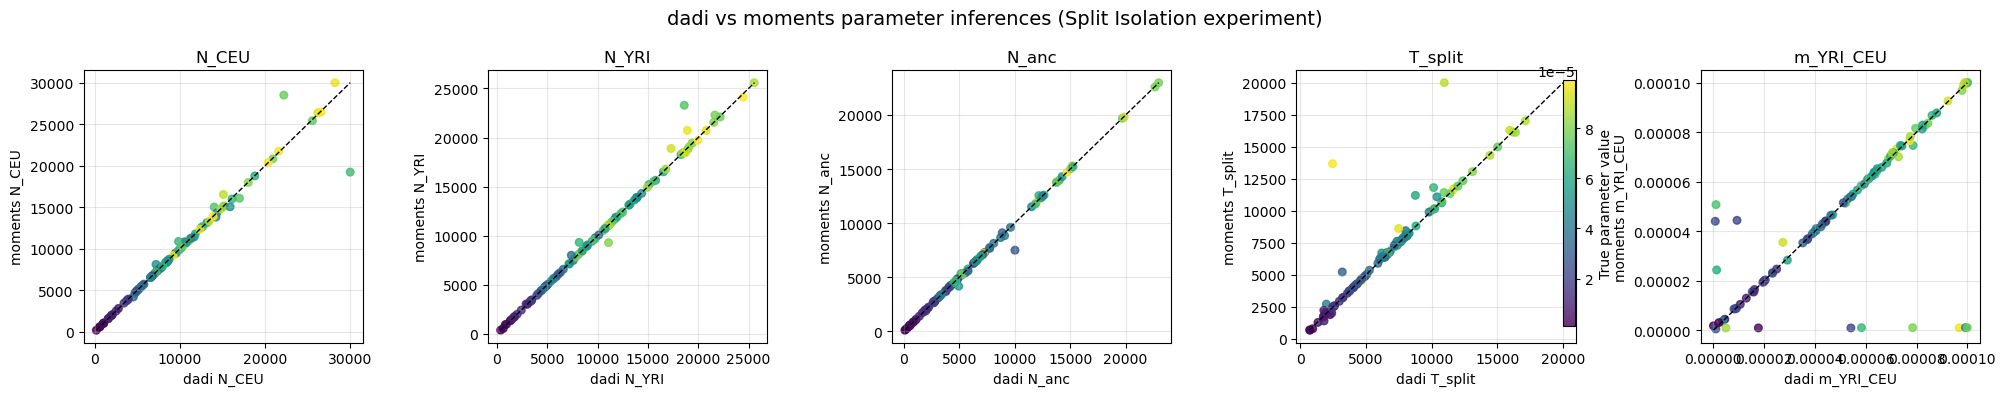

In [1]:
# Plot dadi vs moments inferences for bottleneck experiment - CORRECTED VERSION
import pickle
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Load data from all_inferences.pkl files across simulations
exp_root = Path('/home/akapoor/kernlab/Infer_Demography/experiments/split_isolation')
sim_dirs = sorted([d for d in exp_root.glob('inferences/sim_*') if d.is_dir()])

dadi_estimates = {}
moments_estimates = {}
true_params = {}

# Collect data from all simulations
for sim_dir in sim_dirs:
    sim_id = sim_dir.name.split('_')[1]  # Extract sim number
    all_inferences_file = sim_dir / 'all_inferences.pkl'
    true_params_file = exp_root / f'simulations/{sim_id}/sampled_params.pkl'
    
    if all_inferences_file.exists() and true_params_file.exists():
        try:
            # Load inferences
            with open(all_inferences_file, 'rb') as f:
                all_inferences = pickle.load(f)
            
            # Load true parameters
            with open(true_params_file, 'rb') as f:
                true_vals = pickle.load(f)
            
            # Extract dadi and moments parameters - CORRECTED FOR LIST FORMAT
            if 'dadi' in all_inferences and 'moments' in all_inferences:
                dadi_params = all_inferences['dadi']['best_params']
                moments_params = all_inferences['moments']['best_params']
                
                # Handle list of parameter dictionaries (take the best/first one)
                if isinstance(dadi_params, list) and len(dadi_params) > 0:
                    dadi_best = dadi_params[0]  # Take first (best) fit
                else:
                    dadi_best = dadi_params
                    
                if isinstance(moments_params, list) and len(moments_params) > 0:
                    moments_best = moments_params[0]  # Take first (best) fit  
                else:
                    moments_best = moments_params
                
                if isinstance(dadi_best, dict) and isinstance(moments_best, dict):
                    # Find common parameters between both methods
                    common_param_names = set(dadi_best.keys()) & set(moments_best.keys())
                    
                    for param in common_param_names:
                        if param not in dadi_estimates:
                            dadi_estimates[param] = []
                            moments_estimates[param] = []
                            true_params[param] = []
                        
                        dadi_estimates[param].append(dadi_best[param])
                        moments_estimates[param].append(moments_best[param])
                        true_params[param].append(true_vals.get(param, np.nan))
                        
        except Exception as e:
            print(f"Error loading sim {sim_id}: {e}")
            continue

# Get common parameters
common_params = sorted(set(dadi_estimates.keys()) & set(moments_estimates.keys()) & set(true_params.keys()))
print(f"Common parameters found: {common_params}")
print(f"Number of simulations loaded: {len(dadi_estimates.get(common_params[0], []))}")

# Create plots
n_params = len(common_params)
if n_params > 0:
    fig, axes = plt.subplots(1, n_params, figsize=(4 * n_params, 4))
    if n_params == 1:
        axes = [axes]

    for i, param in enumerate(common_params):
        ax = axes[i]
        x = np.array(dadi_estimates[param])
        y = np.array(moments_estimates[param])
        true_vals = np.array(true_params[param])
        
        # Create scatter plot colored by true values
        scatter = ax.scatter(x, y, c=true_vals, cmap='viridis', s=30, alpha=0.8)
        
        # Add 1:1 line
        min_val = min(x.min(), y.min())
        max_val = max(x.max(), y.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1, label='1:1 line')
        
        ax.set_xlabel(f'dadi {param}')
        ax.set_ylabel(f'moments {param}')
        ax.set_title(f'{param}')
        ax.grid(True, alpha=0.3)

    # Add colorbar
    plt.colorbar(scatter, ax=axes, label='True parameter value', shrink=0.8)
    plt.suptitle('dadi vs moments parameter inferences (Split Isolation experiment)', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("No common parameters found to plot")

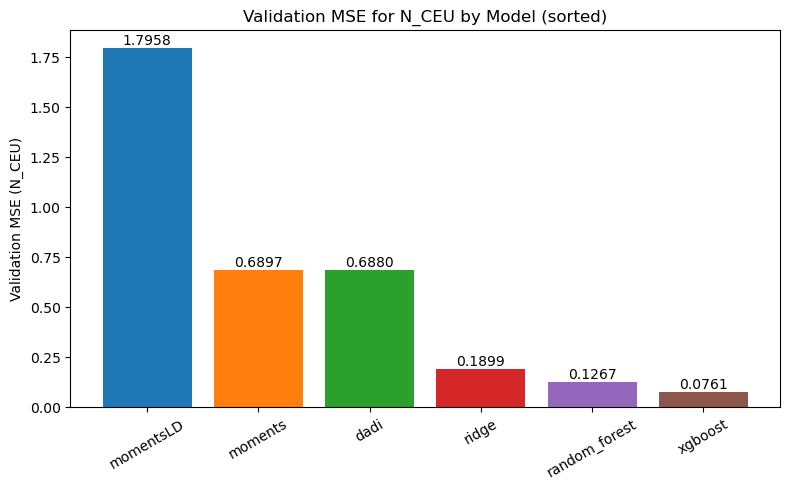

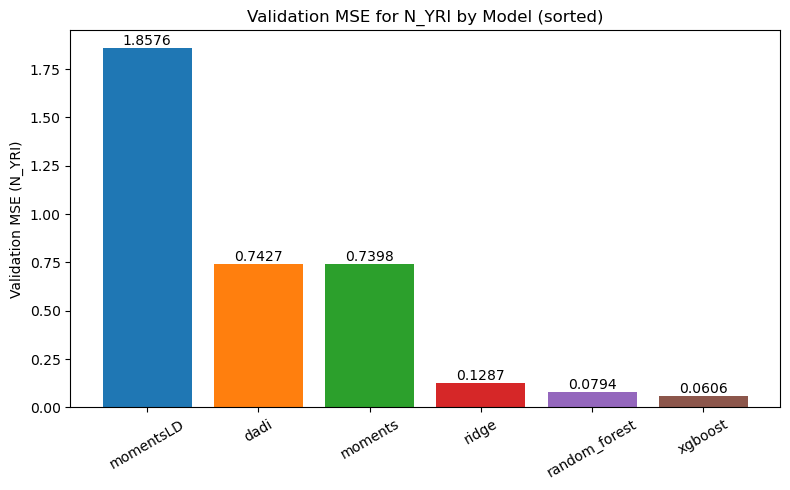

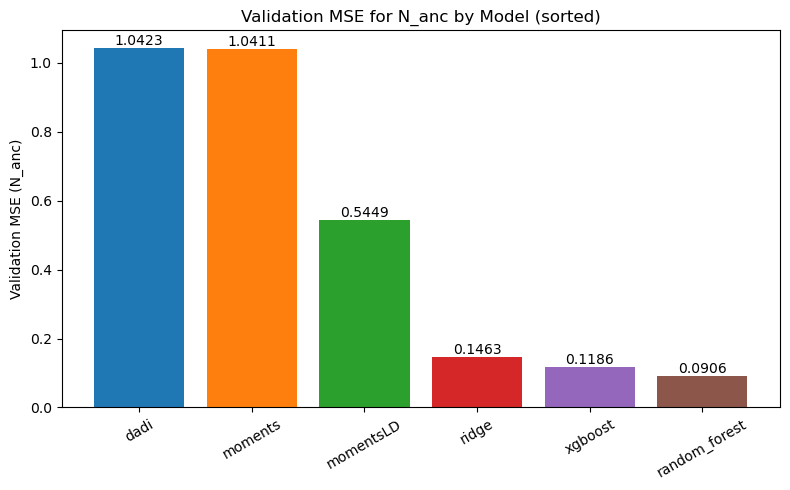

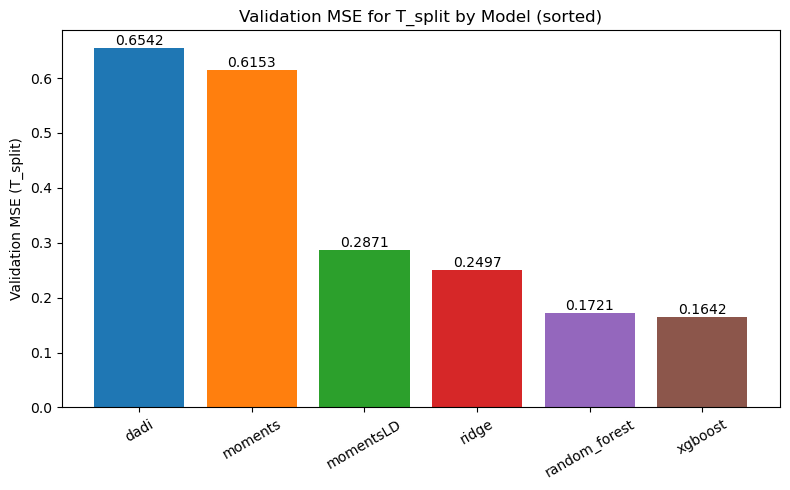

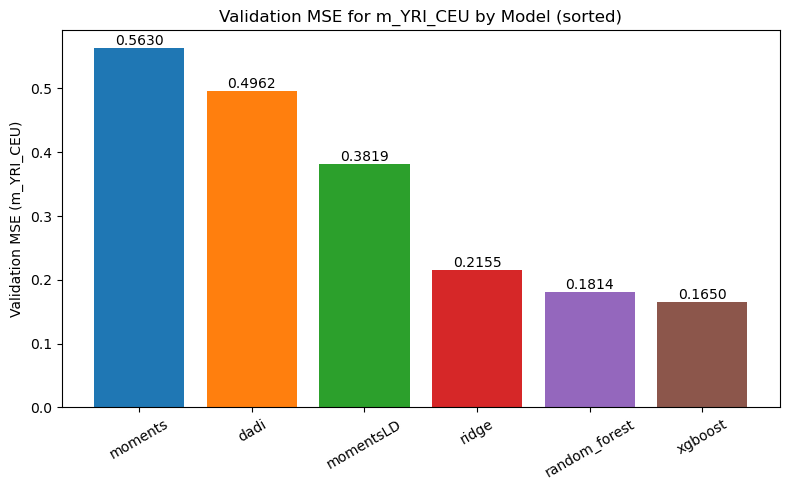

In [9]:
# Bar chart of validation MSE for all demographic parameters across models, sorted from highest to lowest
import json
import matplotlib.pyplot as plt

experiment_name = 'split_isolation'

metrics_path = f'/home/akapoor/kernlab/Infer_Demography/experiments/{experiment_name}/modeling/datasets/metrics_all.json'
ridge_path = f'/home/akapoor/kernlab/Infer_Demography/experiments/{experiment_name}/modeling/linear_ridge/linear_model_error_ridge.json'
rf_path = f'/home/akapoor/kernlab/Infer_Demography/experiments/{experiment_name}/modeling/random_forest/random_forest_model_error.json'
xgb_path = f'/home/akapoor/kernlab/Infer_Demography/experiments/{experiment_name}/modeling/xgboost/xgb_model_error.json'

with open(metrics_path) as f:
    metrics = json.load(f)
with open(ridge_path) as f:
    ridge = json.load(f)
with open(rf_path) as f:
    rf = json.load(f)
with open(xgb_path) as f:
    xgb = json.load(f)

# Get all demographic parameters from one of the validation_mse dicts (assuming all have same keys)
param_keys = set()
for model_dict in [metrics.get('dadi', {}), metrics.get('moments', {}), metrics.get('momentsLD', {}), ridge, rf, xgb]:
    if 'validation_mse' in model_dict:
        param_keys.update(model_dict['validation_mse'].keys())
param_keys = sorted(param_keys)

models = ['dadi', 'moments', 'momentsLD', 'ridge', 'random_forest', 'xgboost']
model_dicts = [metrics['dadi'], metrics['moments'], metrics['momentsLD'], ridge, rf, xgb]

for param in param_keys:
    mse_dict = {}
    for model, m_dict in zip(models, model_dicts):
        val = m_dict.get('validation_mse', {}).get(param, None)
        mse_dict[model] = val

    # Sort models by MSE descending (None treated as lowest)
    sorted_items = sorted(mse_dict.items(), key=lambda x: (x[1] is not None, x[1]), reverse=True)
    sorted_models = [x[0] for x in sorted_items]
    sorted_mse = [x[1] for x in sorted_items]

    plt.figure(figsize=(8,5))
    bars = plt.bar(sorted_models, sorted_mse, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
    plt.ylabel(f'Validation MSE ({param})')
    plt.title(f'Validation MSE for {param} by Model (sorted)')
    plt.xticks(rotation=30)

    # Annotate values
    for i, v in enumerate(sorted_mse):
        plt.text(i, v if v is not None else 0.01, f'{v:.4f}' if v is not None else 'Missing', ha='center', va='bottom', color='black', fontsize=10)

    plt.tight_layout()
    plt.show()

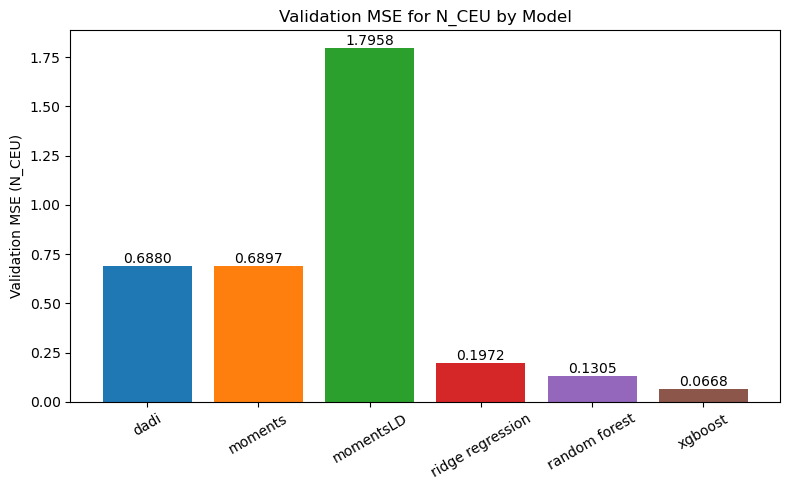

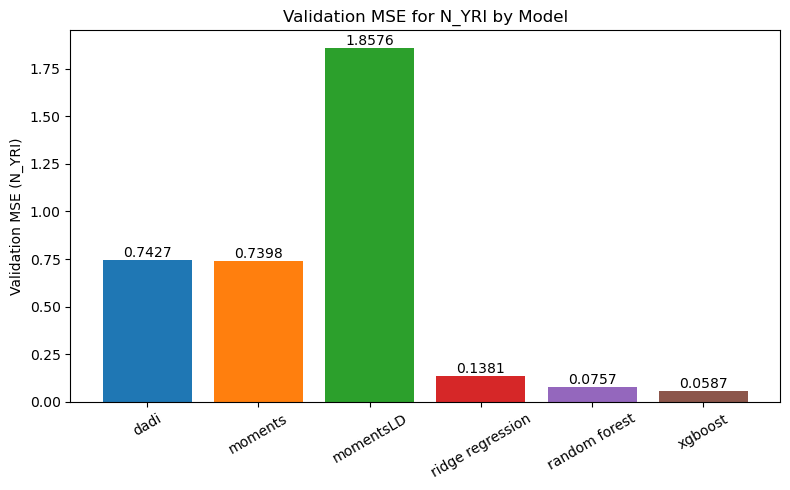

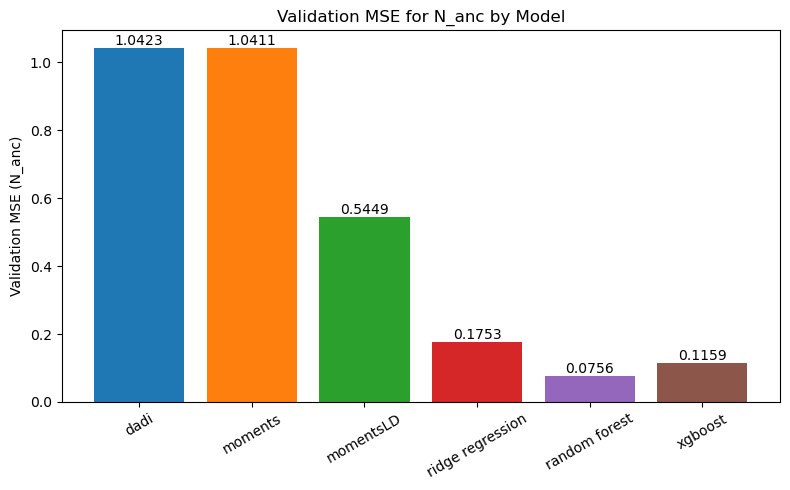

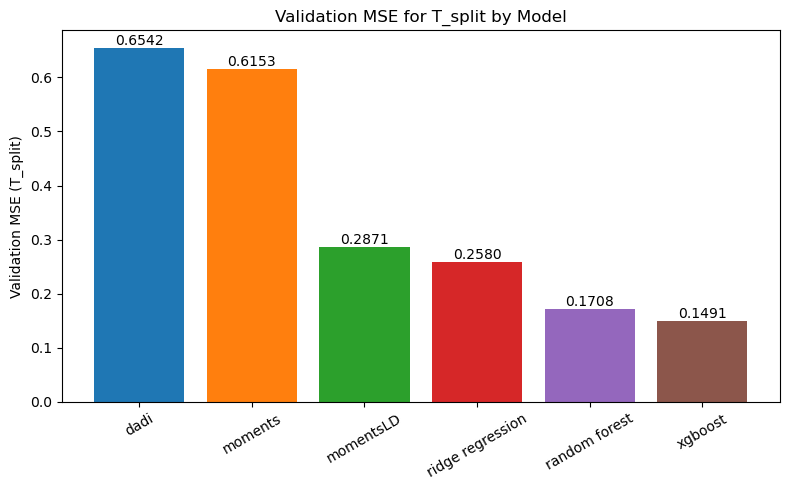

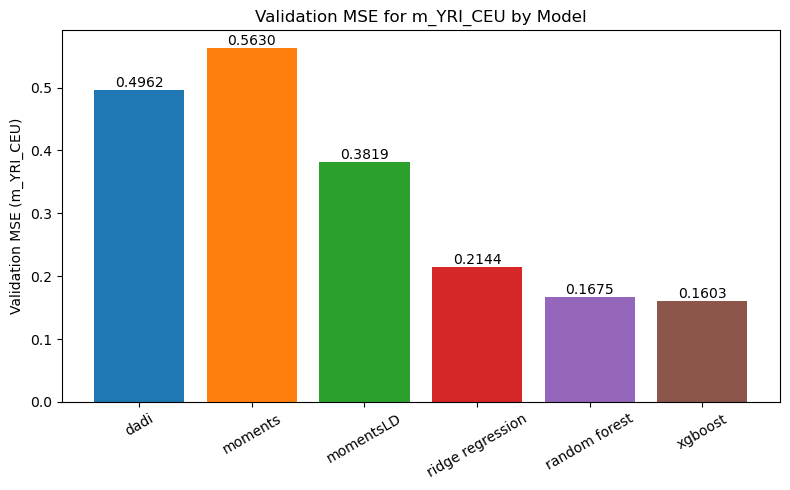

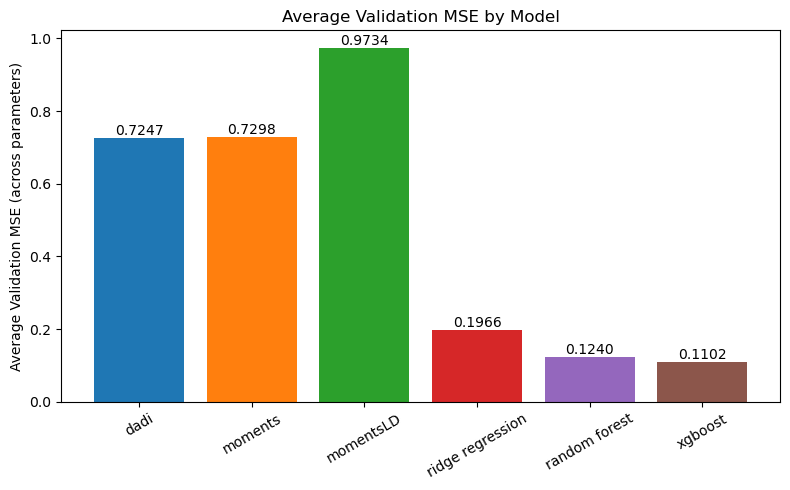

In [3]:
# Bar chart of validation MSE for all demographic parameters with fixed model order
import json
import matplotlib.pyplot as plt
import numpy as np

experiment_name = 'split_isolation'
metrics_path = f'/home/akapoor/kernlab/Infer_Demography/experiments/{experiment_name}/modeling/datasets/metrics_all.json'
ridge_path = f'/home/akapoor/kernlab/Infer_Demography/experiments/{experiment_name}/modeling/linear_ridge/linear_model_error_ridge.json'
rf_path = f'/home/akapoor/kernlab/Infer_Demography/experiments/{experiment_name}/modeling/random_forest/random_forest_model_error.json'
xgb_path = f'/home/akapoor/kernlab/Infer_Demography/experiments/{experiment_name}/modeling/xgboost/xgb_model_error.json'

with open(metrics_path) as f:
    metrics = json.load(f)
with open(ridge_path) as f:
    ridge = json.load(f)
with open(rf_path) as f:
    rf = json.load(f)
with open(xgb_path) as f:
    xgb = json.load(f)

# Fixed model order and display names
models = ['dadi', 'moments', 'momentsLD', 'ridge', 'random_forest', 'xgboost']
display_names = ['dadi', 'moments', 'momentsLD', 'ridge regression', 'random forest', 'xgboost']
model_dicts = [metrics['dadi'], metrics['moments'], metrics['momentsLD'], ridge, rf, xgb]

# Get all demographic parameters from one of the validation_mse dicts (assuming all have same keys)
param_keys = set()
for m_dict in model_dicts:
    if 'validation_mse' in m_dict:
        param_keys.update(m_dict['validation_mse'].keys())
param_keys = sorted(param_keys)

for param in param_keys:
    mse_dict = {}
    for model, m_dict in zip(models, model_dicts):
        val = m_dict.get('validation_mse', {}).get(param, None)
        mse_dict[model] = val

    # Use fixed order
    ordered_mse = [mse_dict[m] for m in models]

    plt.figure(figsize=(8,5))
    bars = plt.bar(display_names, ordered_mse, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
    plt.ylabel(f'Validation MSE ({param})')
    plt.title(f'Validation MSE for {param} by Model')
    plt.xticks(rotation=30)

    # Annotate values
    for i, v in enumerate(ordered_mse):
        plt.text(i, v if v is not None else 0.01, f'{v:.4f}' if v is not None else 'Missing', ha='center', va='bottom', color='black', fontsize=10)

    plt.tight_layout()
    plt.show()

# Rolled-up bar chart: average MSE per method across all parameters
avg_mse = []
for model, m_dict in zip(models, model_dicts):
    vals = list(m_dict.get('validation_mse', {}).values())
    vals = [v for v in vals if v is not None]
    avg = np.mean(vals) if vals else np.nan
    avg_mse.append(avg)

plt.figure(figsize=(8,5))
bars = plt.bar(display_names, avg_mse, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
plt.ylabel('Average Validation MSE (across parameters)')
plt.title('Average Validation MSE by Model')
plt.xticks(rotation=30)

for i, v in enumerate(avg_mse):
    plt.text(i, v if not np.isnan(v) else 0.01, f'{v:.4f}' if not np.isnan(v) else 'Missing', ha='center', va='bottom', color='black', fontsize=10)

plt.tight_layout()
plt.show()

In [4]:
# Table of validation MSEs: methods as columns, parameters as rows
import json
import pandas as pd

experiment_name = 'split_isolation'

metrics_path = f'/home/akapoor/kernlab/Infer_Demography/experiments/{experiment_name}/modeling/datasets/metrics_all.json'
ridge_path = f'/home/akapoor/kernlab/Infer_Demography/experiments/{experiment_name}/modeling/linear_ridge/linear_model_error_ridge.json'
rf_path = f'/home/akapoor/kernlab/Infer_Demography/experiments/{experiment_name}/modeling/random_forest/random_forest_model_error.json'
xgb_path = f'/home/akapoor/kernlab/Infer_Demography/experiments/{experiment_name}/modeling/xgboost/xgb_model_error.json'

with open(metrics_path) as f:
    metrics = json.load(f)
with open(ridge_path) as f:
    ridge = json.load(f)
with open(rf_path) as f:
    rf = json.load(f)
with open(xgb_path) as f:
    xgb = json.load(f)

# Fixed model order and display names
models = ['dadi', 'moments', 'momentsLD', 'ridge', 'random_forest', 'xgboost']
display_names = ['dadi', 'moments', 'momentsLD', 'ridge regression', 'random forest', 'xgboost']
model_dicts = [metrics['dadi'], metrics['moments'], metrics['momentsLD'], ridge, rf, xgb]

# Get all demographic parameters from one of the validation_mse dicts (assuming all have same keys)
param_keys = set()
for m_dict in model_dicts:
    if 'validation_mse' in m_dict:
        param_keys.update(m_dict['validation_mse'].keys())
param_keys = sorted(param_keys)

# Build table
table = []
for param in param_keys:
    row = []
    for m_dict in model_dicts:
        val = m_dict.get('validation_mse', {}).get(param, None)
        row.append(val)
    table.append(row)

df = pd.DataFrame(table, index=param_keys, columns=display_names)
df_display = df.round(4).fillna('Missing')
df_display

,dadi,moments,momentsLD,ridge regression,random forest,xgboost
N_CEU,0.7664,0.7177,2.1812,0.1868,0.1771,0.0928
N_YRI,0.6809,0.6821,2.1955,0.1922,0.1249,0.1534
N_anc,0.5961,0.5918,0.3225,0.2417,0.0987,0.1551
T_split,0.9385,0.4323,0.2301,0.5453,0.2878,0.2825
m_YRI_CEU,1.0725,0.7000,0.5620,0.1680,0.2275,0.3325


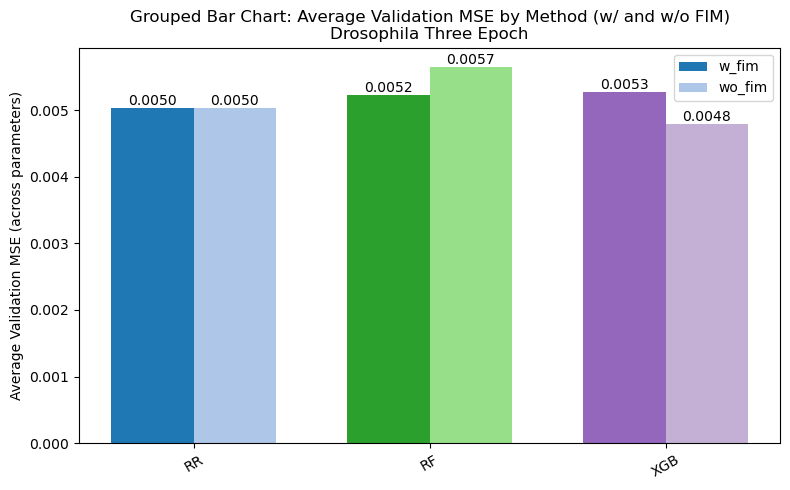

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np

# File paths for model error JSONs
base = "/home/akapoor/kernlab/Infer_Demography/experiments/drosophila_three_epoch"
paths = {
    "RR_w_fim": f"{base}/modeling/linear_ridge/linear_model_error_ridge.json",
    "RR_wo_fim": f"{base}/modeling_wo_fim/linear_ridge/linear_model_error_ridge.json",
    "RF_w_fim": f"{base}/modeling/random_forest/random_forest_model_error.json",
    "RF_wo_fim": f"{base}/modeling_wo_fim/random_forest/random_forest_model_error.json",
    "XGB_w_fim": f"{base}/modeling/xgboost/xgb_model_error.json",
    "XGB_wo_fim": f"{base}/modeling_wo_fim/xgboost/xgb_model_error.json",
}

def load_avg_mse(path):
    with open(path, "r") as f:
        data = json.load(f)
    vals = list(data["validation_mse"].values())
    vals = [v for v in vals if v is not None]
    return np.mean(vals) if vals else np.nan

methods = ["RR", "RF", "XGB"]
labels = ["RR", "RF", "XGB"]
mse_w_fim = [load_avg_mse(paths[f"{m}_w_fim"]) for m in methods]
mse_wo_fim = [load_avg_mse(paths[f"{m}_wo_fim"]) for m in methods]

x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots(figsize=(8,5))
bars1 = ax.bar(x - width/2, mse_w_fim, width, label="w_fim", color=["#1f77b4", "#2ca02c", "#9467bd"] )
bars2 = ax.bar(x + width/2, mse_wo_fim, width, label="wo_fim", color=["#aec7e8", "#98df8a", "#c5b0d5"] )
ax.set_ylabel("Average Validation MSE (across parameters)")
ax.set_title("Grouped Bar Chart: Average Validation MSE by Method (w/ and w/o FIM)\nDrosophila Three Epoch")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=30)
ax.legend()
for i in range(len(labels)):
    ax.text(x[i] - width/2, mse_w_fim[i], f'{mse_w_fim[i]:.4f}', ha='center', va='bottom', color='black', fontsize=10)
    ax.text(x[i] + width/2, mse_wo_fim[i], f'{mse_wo_fim[i]:.4f}', ha='center', va='bottom', color='black', fontsize=10)
plt.tight_layout()
plt.show()

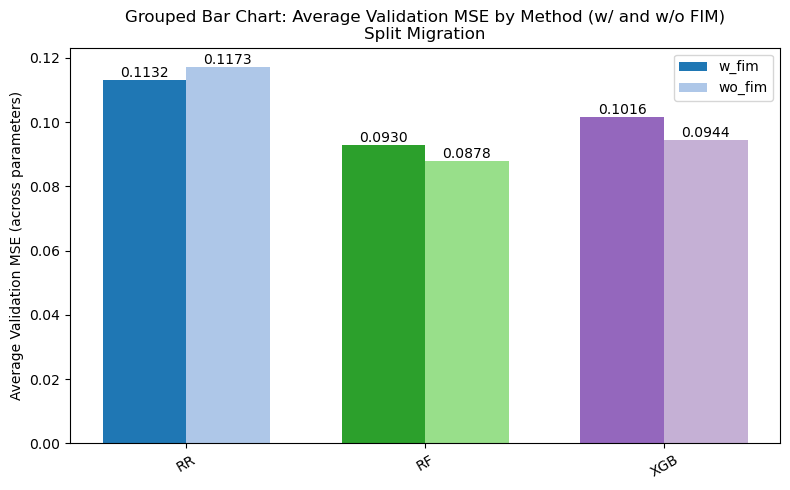

In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np

# File paths for model error JSONs
base = "/home/akapoor/kernlab/Infer_Demography/experiments/split_migration"
paths = {
    "RR_w_fim": f"{base}/modeling/linear_ridge/linear_model_error_ridge.json",
    "RR_wo_fim": f"{base}/modeling_wo_fim/linear_ridge/linear_model_error_ridge.json",
    "RF_w_fim": f"{base}/modeling/random_forest/random_forest_model_error.json",
    "RF_wo_fim": f"{base}/modeling_wo_fim/random_forest/random_forest_model_error.json",
    "XGB_w_fim": f"{base}/modeling/xgboost/xgb_model_error.json",
    "XGB_wo_fim": f"{base}/modeling_wo_fim/xgboost/xgb_model_error.json",
}

def load_avg_mse(path):
    with open(path, "r") as f:
        data = json.load(f)
    vals = list(data["validation_mse"].values())
    vals = [v for v in vals if v is not None]
    return np.mean(vals) if vals else np.nan

methods = ["RR", "RF", "XGB"]
labels = ["RR", "RF", "XGB"]
mse_w_fim = [load_avg_mse(paths[f"{m}_w_fim"]) for m in methods]
mse_wo_fim = [load_avg_mse(paths[f"{m}_wo_fim"]) for m in methods]

x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots(figsize=(8,5))
bars1 = ax.bar(x - width/2, mse_w_fim, width, label="w_fim", color=["#1f77b4", "#2ca02c", "#9467bd"] )
bars2 = ax.bar(x + width/2, mse_wo_fim, width, label="wo_fim", color=["#aec7e8", "#98df8a", "#c5b0d5"] )
ax.set_ylabel("Average Validation MSE (across parameters)")
ax.set_title("Grouped Bar Chart: Average Validation MSE by Method (w/ and w/o FIM)\nSplit Migration")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=30)
ax.legend()
for i in range(len(labels)):
    ax.text(x[i] - width/2, mse_w_fim[i], f'{mse_w_fim[i]:.4f}', ha='center', va='bottom', color='black', fontsize=10)
    ax.text(x[i] + width/2, mse_wo_fim[i], f'{mse_wo_fim[i]:.4f}', ha='center', va='bottom', color='black', fontsize=10)
plt.tight_layout()
plt.show()

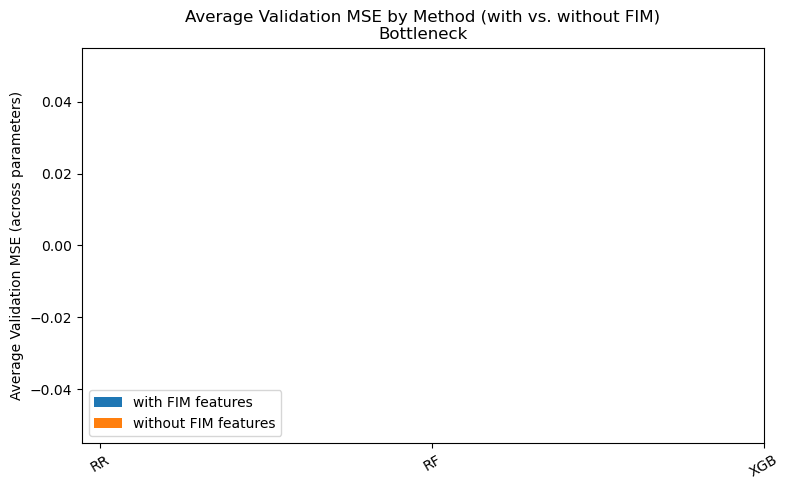

In [4]:
import json, os
import matplotlib.pyplot as plt
import numpy as np

base = "/home/akapoor/kernlab/Infer_Demography/experiments/split_isolation"
paths = {
    "RR_w_FIM":  f"{base}/modeling/linear_ridge/linear_model_error_ridge.json",
    "RR":        f"{base}/modeling_wo_fim/linear_ridge/linear_model_error_ridge.json",
    "RF_w_FIM":  f"{base}/modeling/random_forest/random_forest_model_error.json",
    "RF":        f"{base}/modeling_wo_fim/random_forest/random_forest_model_error.json",
    "XGB_w_FIM": f"{base}/modeling/xgboost/xgb_model_error.json",
    "XGB":       f"{base}/modeling_wo_fim/xgboost/xgb_model_error.json",
}

def load_avg_mse(path):
    if not os.path.exists(path):
        return np.nan
    with open(path, "r") as f:
        data = json.load(f)
    vals = [v for v in data.get("validation_mse", {}).values() if v is not None]
    return float(np.mean(vals)) if vals else np.nan

methods = ["RR", "RF", "XGB"]
labels  = methods

mse_w  = [load_avg_mse(paths[f"{m}_w_FIM"]) for m in methods]
mse_wo = [load_avg_mse(paths[m])            for m in methods]

x = np.arange(len(labels)); width = 0.35
fig, ax = plt.subplots(figsize=(8,5))
bars1 = ax.bar(x - width/2, mse_w,  width, label="with FIM features")
bars2 = ax.bar(x + width/2, mse_wo, width, label="without FIM features")
ax.set_ylabel("Average Validation MSE (across parameters)")
ax.set_title("Average Validation MSE by Method (with vs. without FIM)\nBottleneck")
ax.set_xticks(x); ax.set_xticklabels(labels, rotation=30)
ax.legend()
for i in range(len(labels)):
    if not np.isnan(mse_w[i]):
        ax.text(x[i] - width/2, mse_w[i],  f'{mse_w[i]:.4f}',  ha='center', va='bottom', fontsize=9)
    if not np.isnan(mse_wo[i]):
        ax.text(x[i] + width/2, mse_wo[i], f'{mse_wo[i]:.4f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

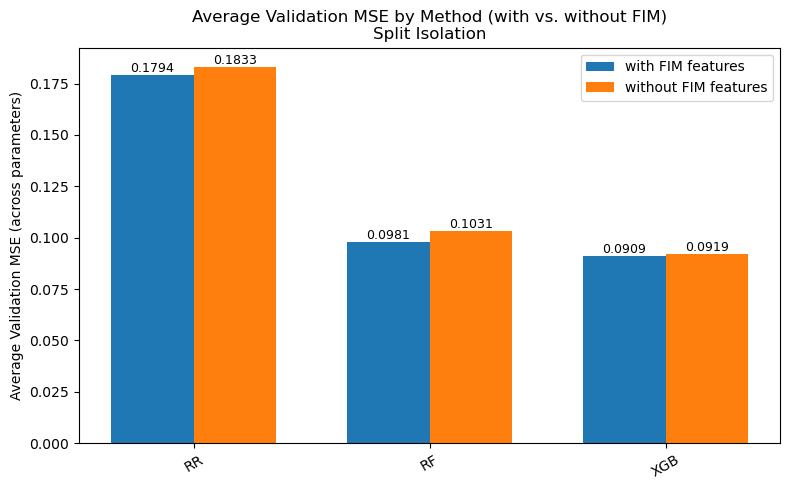

In [7]:
import json, os
import matplotlib.pyplot as plt
import numpy as np

base = "/home/akapoor/kernlab/Infer_Demography/experiments/split_isolation"
paths = {
    "RR_w_FIM":  f"{base}/modeling_w_FIM_wo_SFSresids/linear_ridge/linear_model_error_ridge.json",
    "RR":        f"{base}/modeling_wo_FIM_wo_SFSresids/linear_ridge/linear_model_error_ridge.json",
    "RF_w_FIM":  f"{base}/modeling_w_FIM_wo_SFSresids/random_forest/random_forest_model_error.json",
    "RF":        f"{base}/modeling_wo_FIM_wo_SFSresids/random_forest/random_forest_model_error.json",
    "XGB_w_FIM": f"{base}/modeling_w_FIM_wo_SFSresids/xgboost/xgb_model_error.json",
    "XGB":       f"{base}/modeling_wo_FIM_wo_SFSresids/xgboost/xgb_model_error.json",
}

def load_avg_mse(path):
    if not os.path.exists(path):
        return np.nan
    with open(path, "r") as f:
        data = json.load(f)
    vals = [v for v in data.get("validation_mse", {}).values() if v is not None]
    return float(np.mean(vals)) if vals else np.nan

methods = ["RR", "RF", "XGB"]
labels  = methods

mse_w  = [load_avg_mse(paths[f"{m}_w_FIM"]) for m in methods]
mse_wo = [load_avg_mse(paths[m])            for m in methods]

x = np.arange(len(labels)); width = 0.35
fig, ax = plt.subplots(figsize=(8,5))
bars1 = ax.bar(x - width/2, mse_w,  width, label="with FIM features")
bars2 = ax.bar(x + width/2, mse_wo, width, label="without FIM features")
ax.set_ylabel("Average Validation MSE (across parameters)")
ax.set_title("Average Validation MSE by Method (with vs. without FIM)\nSplit Isolation")
ax.set_xticks(x); ax.set_xticklabels(labels, rotation=30)
ax.legend()
for i in range(len(labels)):
    if not np.isnan(mse_w[i]):
        ax.text(x[i] - width/2, mse_w[i],  f'{mse_w[i]:.4f}',  ha='center', va='bottom', fontsize=9)
    if not np.isnan(mse_wo[i]):
        ax.text(x[i] + width/2, mse_wo[i], f'{mse_wo[i]:.4f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# Looking at SFS Residuals

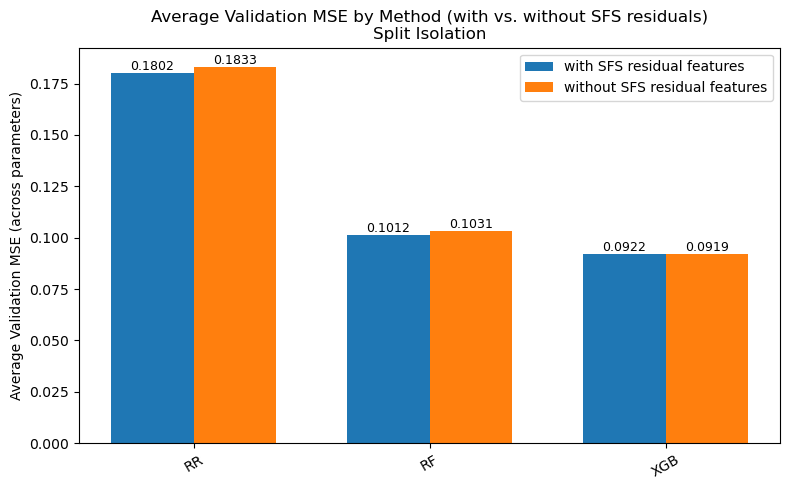

In [2]:
import json, os
import matplotlib.pyplot as plt
import numpy as np

base = "/home/akapoor/kernlab/Infer_Demography/experiments/split_isolation"
paths = {
    "RR_w_SFSresids":  f"{base}/modeling_wo_FIM_w_SFSresids/linear_ridge/linear_model_error_ridge.json",
    "RR":              f"{base}/modeling_wo_FIM_wo_SFSresids/linear_ridge/linear_model_error_ridge.json",
    "RF_w_SFSresids":  f"{base}/modeling_wo_FIM_w_SFSresids/random_forest/random_forest_model_error.json",
    "RF":              f"{base}/modeling_wo_FIM_wo_SFSresids/random_forest/random_forest_model_error.json",
    "XGB_w_SFSresids": f"{base}/modeling_wo_FIM_w_SFSresids/xgboost/xgb_model_error.json",
    "XGB":             f"{base}/modeling_wo_FIM_wo_SFSresids/xgboost/xgb_model_error.json",
}

def load_avg_mse(path):
    if not os.path.exists(path):
        return np.nan
    with open(path, "r") as f:
        data = json.load(f)
    vals = [v for v in data.get("validation_mse", {}).values() if v is not None]
    return float(np.mean(vals)) if vals else np.nan

methods = ["RR", "RF", "XGB"]
labels  = methods

mse_w  = [load_avg_mse(paths[f"{m}_w_SFSresids"]) for m in methods]
mse_wo = [load_avg_mse(paths[m])                  for m in methods]

x = np.arange(len(labels)); width = 0.35
fig, ax = plt.subplots(figsize=(8,5))
bars1 = ax.bar(x - width/2, mse_w,  width, label="with SFS residual features")
bars2 = ax.bar(x + width/2, mse_wo, width, label="without SFS residual features")
ax.set_ylabel("Average Validation MSE (across parameters)")
ax.set_title("Average Validation MSE by Method (with vs. without SFS residuals)\nSplit Isolation")
ax.set_xticks(x); ax.set_xticklabels(labels, rotation=30)
ax.legend()
for i in range(len(labels)):
    if not np.isnan(mse_w[i]):
        ax.text(x[i] - width/2, mse_w[i],  f'{mse_w[i]:.4f}',  ha='center', va='bottom', fontsize=9)
    if not np.isnan(mse_wo[i]):
        ax.text(x[i] + width/2, mse_wo[i], f'{mse_wo[i]:.4f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

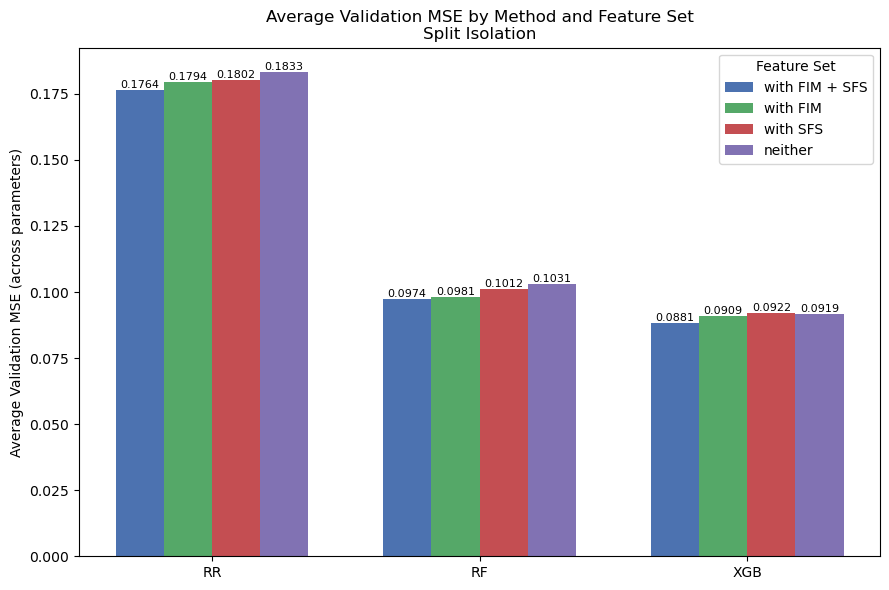

In [8]:
import json, os
import matplotlib.pyplot as plt
import numpy as np

base = "/home/akapoor/kernlab/Infer_Demography/experiments/split_isolation"
paths = {
    "RR_FIM_SFS":  f"{base}/modeling_w_FIM_w_SFSresids/linear_ridge/linear_model_error_ridge.json",
    "RR_FIM":      f"{base}/modeling_w_FIM_wo_SFSresids/linear_ridge/linear_model_error_ridge.json",
    "RR_SFS":      f"{base}/modeling_wo_FIM_w_SFSresids/linear_ridge/linear_model_error_ridge.json",
    "RR_BASE":     f"{base}/modeling_wo_FIM_wo_SFSresids/linear_ridge/linear_model_error_ridge.json",

    "RF_FIM_SFS":  f"{base}/modeling_w_FIM_w_SFSresids/random_forest/random_forest_model_error.json",
    "RF_FIM":      f"{base}/modeling_w_FIM_wo_SFSresids/random_forest/random_forest_model_error.json",
    "RF_SFS":      f"{base}/modeling_wo_FIM_w_SFSresids/random_forest/random_forest_model_error.json",
    "RF_BASE":     f"{base}/modeling_wo_FIM_wo_SFSresids/random_forest/random_forest_model_error.json",

    "XGB_FIM_SFS": f"{base}/modeling_w_FIM_w_SFSresids/xgboost/xgb_model_error.json",
    "XGB_FIM":     f"{base}/modeling_w_FIM_wo_SFSresids/xgboost/xgb_model_error.json",
    "XGB_SFS":     f"{base}/modeling_wo_FIM_w_SFSresids/xgboost/xgb_model_error.json",
    "XGB_BASE":    f"{base}/modeling_wo_FIM_wo_SFSresids/xgboost/xgb_model_error.json",
}

def load_avg_mse(path):
    if not os.path.exists(path):
        return np.nan
    with open(path, "r") as f:
        data = json.load(f)
    vals = [v for v in data.get("validation_mse", {}).values() if v is not None]
    return float(np.mean(vals)) if vals else np.nan

methods = ["RR", "RF", "XGB"]
labels  = ["with FIM + SFS", "with FIM", "with SFS", "neither"]

# collect MSEs for each model and condition
results = []
for m in methods:
    mses = [
        load_avg_mse(paths[f"{m}_FIM_SFS"]),
        load_avg_mse(paths[f"{m}_FIM"]),
        load_avg_mse(paths[f"{m}_SFS"]),
        load_avg_mse(paths[f"{m}_BASE"])
    ]
    results.append(mses)
results = np.array(results)

# plotting
x = np.arange(len(methods))
width = 0.18
fig, ax = plt.subplots(figsize=(9,6))

offsets = np.linspace(-1.5*width, 1.5*width, 4)
colors  = ["#4C72B0", "#55A868", "#C44E52", "#8172B3"]

for i in range(4):
    bars = ax.bar(x + offsets[i], results[:, i], width, label=labels[i], color=colors[i])
    for j in range(len(methods)):
        val = results[j, i]
        if not np.isnan(val):
            ax.text(x[j] + offsets[i], val, f"{val:.4f}",
                    ha="center", va="bottom", fontsize=8)

ax.set_ylabel("Average Validation MSE (across parameters)")
ax.set_title("Average Validation MSE by Method and Feature Set\nSplit Isolation")
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend(title="Feature Set")
plt.tight_layout()
plt.show()
